<a href="https://colab.research.google.com/github/DM2003/DEEP-LEARNING-PROJECTS/blob/main/PAMAP_2_SPECTOGRAM_PART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Channels refer to the different types of measurements or sensors. In our dataset, each sensor on different parts of the body (hand, chest, ankle) has multiple channels:

Temperature: 1 channel per sensor

Acceleration: 3 channels (x, y, z) per sensor

Gyroscope: 3 channels (x, y, z) per

Magnetometer: 3 channels (x, y, z) per sensor

Orientation: 4 channels (x, y, z, w) per sensor

For each sensor, we have a total of 14 channels. Since we have three sensors (hand, chest, ankle), the total number of channels is:

3
 sensors
×
14
 channels/sensor
=
42
 channels



In [ ]:
!wget -O pamap2.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
!unzip pamap2.zip

--2024-07-23 14:30:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘pamap2.zip’

pamap2.zip              [       <=>          ] 656.29M  2.43MB/s    in 1m 58s  

2024-07-23 14:32:20 (5.55 MB/s) - ‘pamap2.zip’ saved [688167640]

Archive:  pamap2.zip
  inflating: PAMAP2_Dataset/Protocol/subject101.dat  
  inflating: PAMAP2_Dataset/Protocol/subject102.dat  
  inflating: PAMAP2_Dataset/Protocol/subject103.dat  
  inflating: PAMAP2_Dataset/Protocol/subject104.dat  
  inflating: PAMAP2_Dataset/Protocol/subject105.dat  
  inflating: PAMAP2_Dataset/Protocol/subject106.dat  
  inflating: PAMAP2_Dataset/Protocol/subject107.dat  
  inflating: PAMAP2_Dataset/Protocol/subject108.dat  
  inflating: PAMAP2_Dataset/Protocol/sub

In [ ]:
import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

import pickle
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

In [ ]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [ ]:
def generate_three_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    return [x, y, z]

def generate_four_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    w = name + '_w'
    return [x, y, z, w]

def generate_cols_IMU(name):
    # temp
    temp = name + '_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name + '_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name + '_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name + '_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name + '_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # orientation
    orientation = name + '_4D_orientation'
    orientation = generate_four_IMU(orientation)
    output.extend(orientation)
    return output

def load_IMU():
    output = ['time_stamp', 'activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

def load_subjects(root='/content/PAMAP2_Dataset/Protocol/subject'):
    all_subjects = []
    cols = load_IMU()

    for i in range(101, 110):
        path = root + str(i) + '.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols
        subject['id'] = i
        all_subjects.append(subject)

    output = pd.concat(all_subjects, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [ ]:
data.head()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


In [ ]:
data.isnull().sum()

time_stamp                          0
activity_id                         0
heart_rate                    2610265
hand_temperature                13141
hand_3D_acceleration_16_x       13141
hand_3D_acceleration_16_y       13141
hand_3D_acceleration_16_z       13141
hand_3D_acceleration_6_x        13141
hand_3D_acceleration_6_y        13141
hand_3D_acceleration_6_z        13141
hand_3D_gyroscope_x             13141
hand_3D_gyroscope_y             13141
hand_3D_gyroscope_z             13141
hand_3D_magnetometer_x          13141
hand_3D_magnetometer_y          13141
hand_3D_magnetometer_z          13141
hand_4D_orientation_x           13141
hand_4D_orientation_y           13141
hand_4D_orientation_z           13141
hand_4D_orientation_w           13141
chest_temperature                3563
chest_3D_acceleration_16_x       3563
chest_3D_acceleration_16_y       3563
chest_3D_acceleration_16_z       3563
chest_3D_acceleration_6_x        3563
chest_3D_acceleration_6_y        3563
chest_3D_acc

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 55 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   time_stamp                  float64
 1   activity_id                 int64  
 2   heart_rate                  float64
 3   hand_temperature            float64
 4   hand_3D_acceleration_16_x   float64
 5   hand_3D_acceleration_16_y   float64
 6   hand_3D_acceleration_16_z   float64
 7   hand_3D_acceleration_6_x    float64
 8   hand_3D_acceleration_6_y    float64
 9   hand_3D_acceleration_6_z    float64
 10  hand_3D_gyroscope_x         float64
 11  hand_3D_gyroscope_y         float64
 12  hand_3D_gyroscope_z         float64
 13  hand_3D_magnetometer_x      float64
 14  hand_3D_magnetometer_y      float64
 15  hand_3D_magnetometer_z      float64
 16  hand_4D_orientation_x       float64
 17  hand_4D_orientation_y       float64
 18  hand_4D_orientation_z       float64
 19  hand_4D_orientation_w

In [ ]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [ ]:
data.isnull().sum()

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [ ]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Number of uniqe activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  9
Number of uniqe activitys in the data:  12


In [ ]:
activity_map = load_activity_map()

In [ ]:
features = data.drop(columns=['time_stamp','activity_id', 'id'], axis = 1)
target = data['activity_id']

In [ ]:
# Convert features and target to NumPy arrays
features_array = features.to_numpy()
target_array = target.to_numpy()

In [ ]:
from scipy.signal import spectrogram
from scipy.signal import stft
from scipy.fft import fft

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


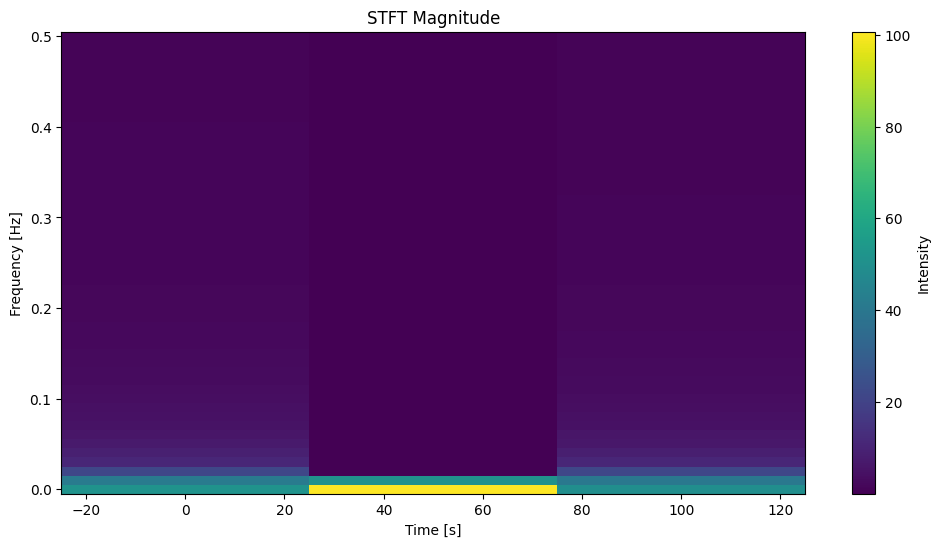

In [ ]:
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt

window_size = 100  # Size of each window
stride = 50  # Overlapping between windows

# Assuming segment_data and features_array are already defined and used
def segment_data(data, window_size, stride): # The function is designed to divide a continuous dataset into overlapping segments or windows.

    segments = [] # Used to store the individual segments or windows of the data as they are created.

    num_windows = (len(data) - window_size) // stride + 1 # Calculates the total number of segments or windows that can be created from the data.
    """len(data) - window_size: Determines how many starting points there are in the data for the window.
      // stride: Divides this by the stride to get the number of full windows that can be created.
      + 1: Includes the last window, which might be partial."""


    for start in range(0, num_windows * stride, stride): # Generates starting indices for the windows, starting from 0 up to (num_windows * stride) with a step size of (stride)
        end = start + window_size # Compute the end index of the window
        segment = data[start:end] # Extract the portion of data from start to end and store it in segment.
        segments.append(segment) # Add the segment to the segments list.

    return np.array(segments) # Only return the segments

# Call the function with a single output
segments = segment_data(features_array, window_size, stride)

# Compute STFT for a single segment and feature (modify as needed).
# STFT provides a time-frequency representation of the signal, showing how the frequency content changes over time.
f, t, Zxx = stft(segments[0][:, 0], fs=1)  # Assuming sampling frequency is 1. Extracts the data of the first feature from the first segment for STFT computation.
"""segments[0]: This selects the first segment from the list of segments.
   [:, 0]: Selects the first feature (column) from the segment. In the context of time-series data with multiple features, this notation is used to pick out one specific feature's data for analysis.
   fs = 1 means the data is sampled once per unit of time
   f: An array of sample frequencies.
   t: Array of segment times.
   Zxx: A 2D complex array, where each element represents the magnitude and phase of the signal at a specific frequency and time."""


# Plot STFT
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='auto')  # Plot the magnitude of Zxx
"""t: Serves as the x-axis in the plot, representing time. This axis shows how the frequency content of the signal evolves over time.
   f: Serves as the y-axis in the plot, representing frequency. This axis shows the range of frequencies present in the signal.
   np.abs(Zxx): The magnitude represents the amplitude of the frequency components at each time and frequency point, without considering phase information.
   These values are used to determine the color of each cell in the plot, indicating the intensity or power of the frequency components at different times."""


plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('STFT Magnitude')
plt.colorbar(label='Intensity')
plt.show()

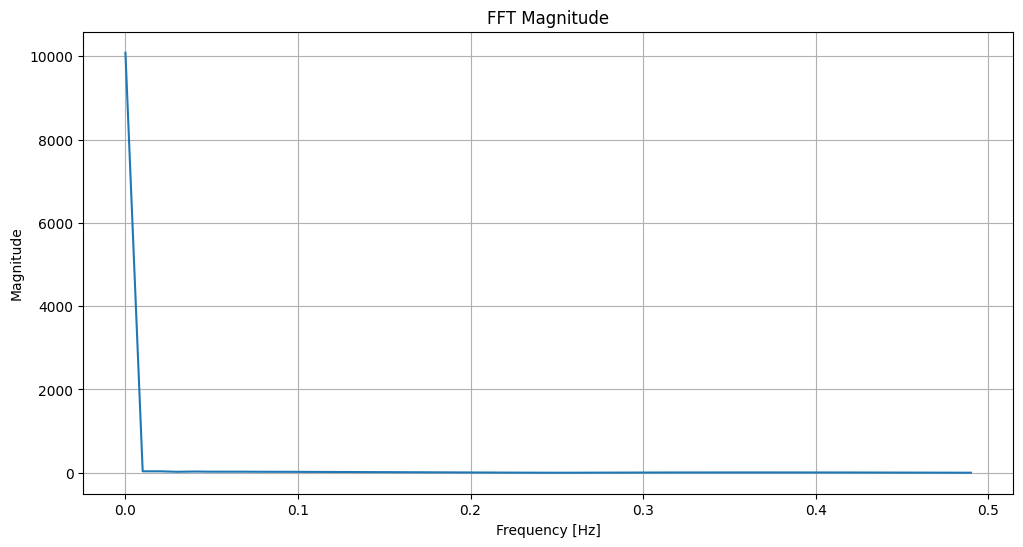

In [ ]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

# Define FFT function
def compute_fft(segment):
    # Compute the FFT of the segment
    fft_result = fft(segment)
    """FFT converts the time-domain signal into the frequency domain.
       The result, fft_result, is a complex array where each element represents a frequency component of the input signal."""
    return np.abs(fft_result) # The magnitude provides information about the strength or amplitude of the frequency components in the signal.

# Select a segment and feature to analyze
segment_index = 0 # Sets the index to 0 which means the first segment in the list or array of segments will be used.
feature_index = 0 # Similarly over here the first feature in the data will be used.

# Extract the specific segment and feature
segment = segments[segment_index][:, feature_index]
"""segments variable is a 3D array where the first dimension represents different segments (slices of time), the second dimension represents time points within each segment, the third dimension represents different features or variables.
   segment_index: This variable specifies which segment to extract
   [:, feature_index]: This part extracts all the time points (:) for a specific feature (feature_index) from the selected segment.
   The result is a 1D array containing the time series data for that feature within the selected segment. """


# Compute FFT
fft_result = compute_fft(segment)

# Define frequency axis
n = len(segment)  # Number of samples in the segment. The variable n represents the total number of data points (time samples) in the segment.
frequencies = np.fft.fftfreq(n, d=1)  # This line computes the frequency bins for the FFT output. The np.fft.fftfreq function returns the discrete Fourier Transform sample frequencies.
"""n: The number of points in the output, which should match the number of samples in the input data (i.e., the segment length).
   d: The sampling interval (the time between successive samples). In this case, d=1 is assumed for simplicity, meaning the sampling rate is 1 sample per unit time."""


# Plot FFT
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:n // 2], fft_result[:n // 2])  # Plot the magnitude of the FFT (only positive frequencies)
"""This part selects the first half of the frequencies array ie: the positive frequencies. FFT result is symmetric for real-valued input signals ie: the second half of the frequencies (corresponding to negative frequencies) is a mirror image of the first half.
   Therefore, only the positive half is typically plotted.
   n // 2 calculates the midpoint index of the array. // is the floor division operator in Python, ensuring that the result is an integer."""


plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('FFT Magnitude')
plt.grid()
plt.show()